## DenseNet with Pytorch

In [3]:
from IPython.display import Image

image_url = 'https://www.researchgate.net/profile/Noha-Radwan-3/publication/334170752/figure/fig5/AS:776225345785857@1562077952441/A-schematic-illustration-of-the-DenseNet-121-architecture-82.png'
print("DenseNet architecture")
Image(url=image_url,height=2000)

DenseNet architecture


In [10]:
import os
import gc
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchview import draw_graph
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
model_parameters={}
model_parameters['densenet121'] = [6,12,24,16]
model_parameters['densenet169'] = [6,12,32,32]
model_parameters['densenet201'] = [6,12,48,32]
model_parameters['densenet264'] = [6,12,64,48]

# growth rate
k = 32
compression_factor = 0.5

## Dense Layer

In [13]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.batchNorm1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4*k, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.batchNorm2 = nn.BatchNorm2d(4*k)
        self.conv2 = nn.Conv2d(in_channels=4*k, out_channels=k, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x_in = x 
        
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.conv1(x)
        
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.conv2(x)
        
        x = torch.cat([x_in, x], dim=1)
        return x

In [14]:
x = torch.randn(1,64,224,224)
model = DenseLayer(64)
print('DenseLayer Output shape : ',model(x).shape)

DenseLayer Output shape :  torch.Size([1, 96, 224, 224])


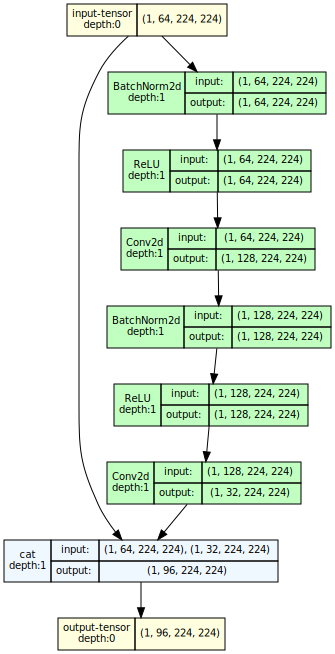

In [16]:
architecture = 'denselayer'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}.png')
model_graph.visual_graph

## Dense block

In [17]:
class DenseBlock(nn.Module):
    def __init__(self, layer_num, in_channels):
        super().__init__()
        
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()
        
        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}", DenseLayer(in_channels+k*num))
            
            
    def forward(self, x):
        for layer in self.deep_nn:
            x = layer(x)
        return x

In [18]:
x = torch.randn(1,3,224,224)
model = DenseBlock(layer_num=3, in_channels=3)
print('Denseblock Output shape : ',model(x).shape)

Denseblock Output shape :  torch.Size([1, 99, 224, 224])


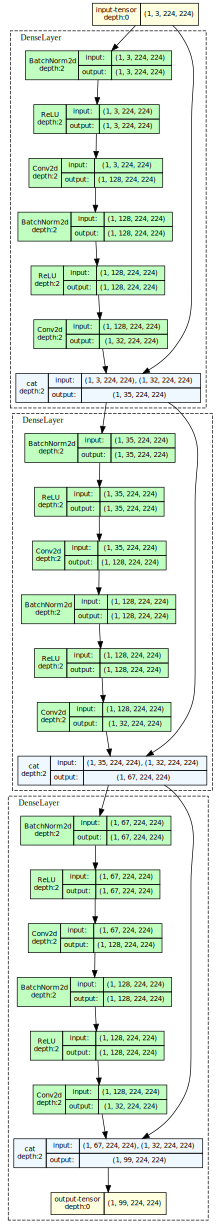

In [19]:
architecture = 'denseblock'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Transition layer

In [20]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, compression_factor):
        super().__init__()
        
        self.batchNorm = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels = int(in_channels*compression_factor), kernel_size=1, stride=1, padding=0, bias=False)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.batchNorm(x)
        x = self.conv(x)
        x = self.avgpool(x)
        return x

In [21]:
x = torch.randn(1,64,224,224)
model = TransitionLayer(64,compression_factor)
print('Transition Layer Output shape : ',model(x).shape)

Transition Layer Output shape :  torch.Size([1, 32, 112, 112])


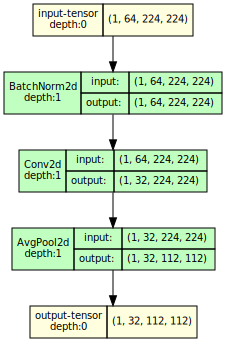

In [22]:
architecture = 'transition'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Dense Net

In [23]:
class DenseNet(nn.Module):
    def __init__(self, densenet_variant, in_channels, num_classes=1000):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 64
        
        for num in range(len(densenet_variant))[:-1]:
            self.deep_nn.add_module(f"DenseBlock_{num+1}", DenseBlock(densenet_variant[num], dense_block_inchannels))
            dense_block_inchannels = int(dense_block_inchannels + k * densenet_variant[num])
            
            self.deep_nn.add_module(f"TranzitionLayer_{num+1}", TransitionLayer(dense_block_inchannels, compression_factor))
            dense_block_inchannels = int(dense_block_inchannels * compression_factor)
            
        self.deep_nn.add_module(f"DenseBlock_{num+2}", DenseBlock(densenet_variant[-1], dense_block_inchannels))
        dense_block_inchannels = int(dense_block_inchannels + k* densenet_variant[-1])
        
        self.batchNorm2 = nn.BatchNorm2d(dense_block_inchannels)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(dense_block_inchannels, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        
        
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        for layer in self.deep_nn:
            x = layer(x)
            
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [24]:
x = torch.randn(1,3,224,224)
model = DenseNet(model_parameters['densenet121'],3)
print('DenseNet Layer Output shape : ',model(x).shape)

DenseNet Layer Output shape :  torch.Size([1, 1000])


In [25]:
architecture = 'denseNet'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=False, expand_nested=True, show_shapes=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph

## Model training with CIFAR100 dataset

In [31]:
num_classes = 100
num_epochs = 10
learning_rate = 0.0001


model = DenseNet(model_parameters['densenet121'],3, num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)  

In [32]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [33]:
dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=data_transforms)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [34]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
    
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print (f"Epoch [{epoch+1}/{num_epochs}]\tLoss: {loss.item():.4f}", end="\t")
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
    print(f"valid accuracy : {correct / total}") 

Epoch [1/10]	Loss: 3.2100	valid accuracy : 0.1644
Epoch [2/10]	Loss: 3.0145	valid accuracy : 0.2534
Epoch [3/10]	Loss: 2.6771	valid accuracy : 0.3306
Epoch [4/10]	Loss: 2.3236	valid accuracy : 0.401
Epoch [5/10]	Loss: 2.0279	valid accuracy : 0.4488
Epoch [6/10]	Loss: 1.6965	valid accuracy : 0.4766
Epoch [7/10]	Loss: 1.2299	valid accuracy : 0.5084
Epoch [8/10]	Loss: 1.5552	valid accuracy : 0.5104
Epoch [9/10]	Loss: 1.1278	valid accuracy : 0.5412
Epoch [10/10]	Loss: 1.1001	valid accuracy : 0.5434


## Testing model

In [35]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    
print(f"Accuracy of test images : {100 * correct / total} %") 

Accuracy of test images : 55.76 %
